In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import glob

In [6]:
image_dataset = glob.glob("/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/**/*.png", recursive=True)[:100]

In [7]:
mask_dataset = glob.glob("/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/**/*.png", recursive=True)[:100]

In [8]:
seg_color = np.array([(0, 0, 0), 
                    (70, 70, 70),
                    (100, 40, 40),
                    (55, 90, 80),
                    (220, 20, 60),
                    (153, 153, 153),
                    (157, 234, 50),
                    (128, 64, 128),
                    (244, 35, 232),
                    (107, 142, 35),
                    (0, 0, 142),
                    (102, 102, 156),
                    (220, 220, 0),
                    (70, 130, 180),
                    (81, 0, 81),
                    (150, 100, 100),
                    (180, 165, 180),
                    (250, 170, 30),
                    (110, 190, 160),
                    (170, 120, 50),
                    (45, 60, 150),
                    (145, 170, 100)])

In [9]:
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [10]:
def cvtBGR2RGB(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [11]:
image_dataset_arr = []
for path in image_dataset:
  img = cv2.imread(path)
  img = cvtBGR2RGB(img)
  img = cv2.resize(img, (256,256))
  img = img/255
  image_dataset_arr.append(img)

In [12]:
mask_dataset_arr = []
for path in mask_dataset:
  img = cv2.imread(path)
  img = cvtBGR2RGB(img)
  img = cv2.resize(img, (256,256))
  mask_dataset_arr.append(img)

In [13]:
mask_dataset_arr = np.array(mask_dataset_arr)


In [14]:
image_dataset_arr = np.array(image_dataset_arr)

In [86]:
image_dataset_arr.shape

(100, 256, 256, 3)

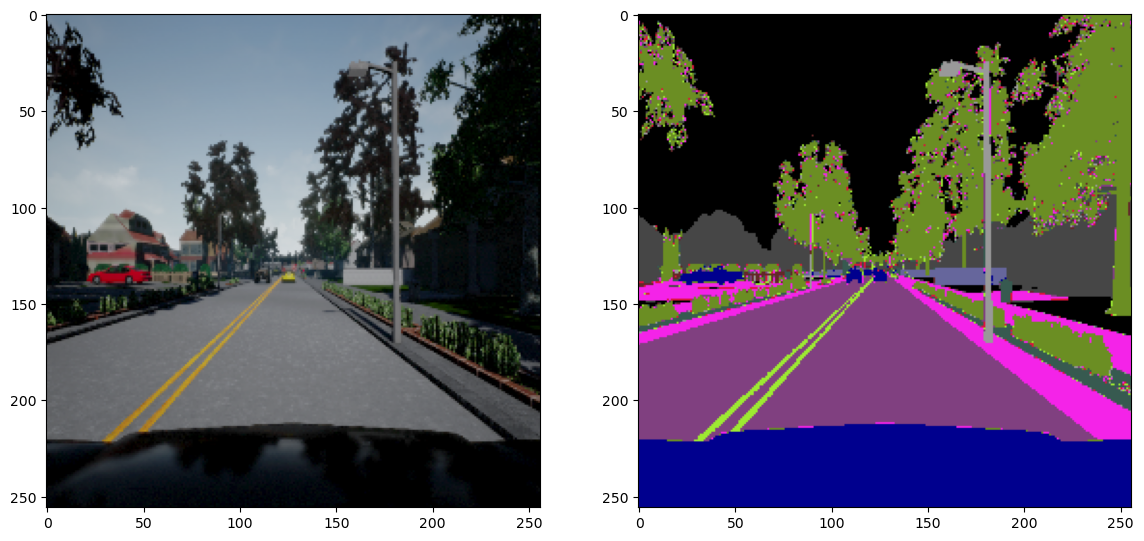

In [16]:
random_num = random.randint(0, len(image_dataset)-1)

fig, ax = plt.subplots(1, 2, figsize=(14,8))
ax[0].imshow(image_dataset_arr[random_num])
ax[1].imshow(seg_color[mask_dataset_arr[random_num][:,:,0]])
plt.show()

In [17]:
mask_dataset_arr = mask_dataset_arr[:,:,:,0]

In [18]:
mask_dataset_arr = np.expand_dims(mask_dataset_arr, axis=-1)

In [19]:
mask_dataset_arr.shape

(100, 256, 256, 1)

In [20]:
mask_labeled_dataset = to_categorical(mask_dataset_arr, num_classes=13)

In [21]:
mask_labeled_dataset.shape

(100, 256, 256, 13)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset_arr, mask_labeled_dataset, test_size=0.2, random_state=42)

In [89]:
X_train[0].shape

(256, 256, 3)

In [24]:
from keras.models import Model
from keras.layers import Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, Input, concatenate

In [25]:
from sklearn.metrics import jaccard_score

In [26]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [27]:
def unet_model(num_classes, height, width, channels):
    
    input = Input((height, width, channels))
    init_input = input
    
    d1 = Conv2D(filters=32 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(init_input)
    d1 = Conv2D(filters=32 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(d1)
    p1 = MaxPooling2D((2,2))(d1)
    
    d2 = Conv2D(filters=64 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(p1)
    d2 = Conv2D(filters=64 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(d2)
    p2 = MaxPooling2D((2,2))(d2)
    
    d3 = Conv2D(filters=128 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(p2)
    d3 = Conv2D(filters=128 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(d3)
    p3 = MaxPooling2D((2,2))(d3)
    
    d4 = Conv2D(filters=256 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(p3)
    d4 = Conv2D(filters=256 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(d4)
    p4 = MaxPooling2D((2,2))(d4)
    
    d5 = Conv2D(filters=512 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(p4)
    d5 = Conv2D(filters=512 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(d5)
    
    u6 = Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(d5)
    u6 = concatenate([d4, u6])
    u6 = Conv2D(filters=256 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(u6)
    u6 = Conv2D(filters=256 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(u6)
    
    u7 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(u6)
    u7 = concatenate([d3, u7])
    u7 = Conv2D(filters=128 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(u7)
    u7 = Conv2D(filters=128 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(u7)
    
    u8 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(u7)
    u8 = concatenate([d2, u8])
    u8 = Conv2D(filters=64 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(u8)
    u8 = Conv2D(filters=64 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(u8)
    
    u9 = Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(u8)
    u9 = concatenate([d1, u9])
    u9 = Conv2D(filters=32 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(u9)
    u9 = Conv2D(filters=32 ,kernel_size=(3,3) ,kernel_initializer='he_normal' , activation='relu', padding='same')(u9)
    
    output = Conv2D(filters=num_classes, kernel_size=(1,1), activation='softmax')(u9)
    
    model = Model(inputs = [input], outputs = [output])
    
    return model
    
    

In [28]:
model = unet_model(13, 256, 256, 3)

In [29]:

weights = [0.0769,0.0769,0.0769,0.0769,0.0769,0.0769,0.0769,0.0769,0.0769,0.0769,0.0769,0.0769,0.0769]
len(weights)

13

In [30]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss =  sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

In [38]:
import tensorflow as tf

In [39]:
model.compile(optimizer='adam', metrics=[['accuracy'],tf.keras.metrics.MeanIoU(num_classes=13)], loss=total_loss )

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [40]:
history = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_test,y_test) , verbose=1)

Epoch 1/100
10/10 [==============================] - 30s 460ms/step - loss: 1.0264 - accuracy: 0.2957 - mean_io_u: 0.4615 - val_loss: 1.0179 - val_accuracy: 0.3718 - val_mean_io_u: 0.4615
Epoch 2/100
10/10 [==============================] - 2s 219ms/step - loss: 1.0196 - accuracy: 0.3349 - mean_io_u: 0.4615 - val_loss: 1.0176 - val_accuracy: 0.4293 - val_mean_io_u: 0.4615
Epoch 3/100
10/10 [==============================] - 2s 217ms/step - loss: 1.0178 - accuracy: 0.3779 - mean_io_u: 0.4615 - val_loss: 1.0143 - val_accuracy: 0.5252 - val_mean_io_u: 0.4615
Epoch 4/100
10/10 [==============================] - 2s 214ms/step - loss: 1.0137 - accuracy: 0.4850 - mean_io_u: 0.4615 - val_loss: 1.0095 - val_accuracy: 0.5217 - val_mean_io_u: 0.4615
Epoch 5/100
10/10 [==============================] - 2s 222ms/step - loss: 1.0092 - accuracy: 0.5030 - mean_io_u: 0.4615 - val_loss: 1.0071 - val_accuracy: 0.5345 - val_mean_io_u: 0.4615
Epoch 6/100
10/10 [==============================] - 2s 225ms/st

In [41]:
y_pred = model.predict(X_test)

1/1 [==============================] - 5s 5s/step


In [43]:
y_pred_max = np.argmax(y_pred, axis=-1)

In [47]:
y_pred_max = np.expand_dims(y_pred_max, axis=-1)

In [49]:
y_pred_max.shape

(20, 256, 256, 1)

In [55]:
y_test_max = np.argmax(y_test,axis=-1)

In [57]:
y_test_max = np.expand_dims(y_test_max, axis=-1)

<function matplotlib.pyplot.show(close=None, block=None)>

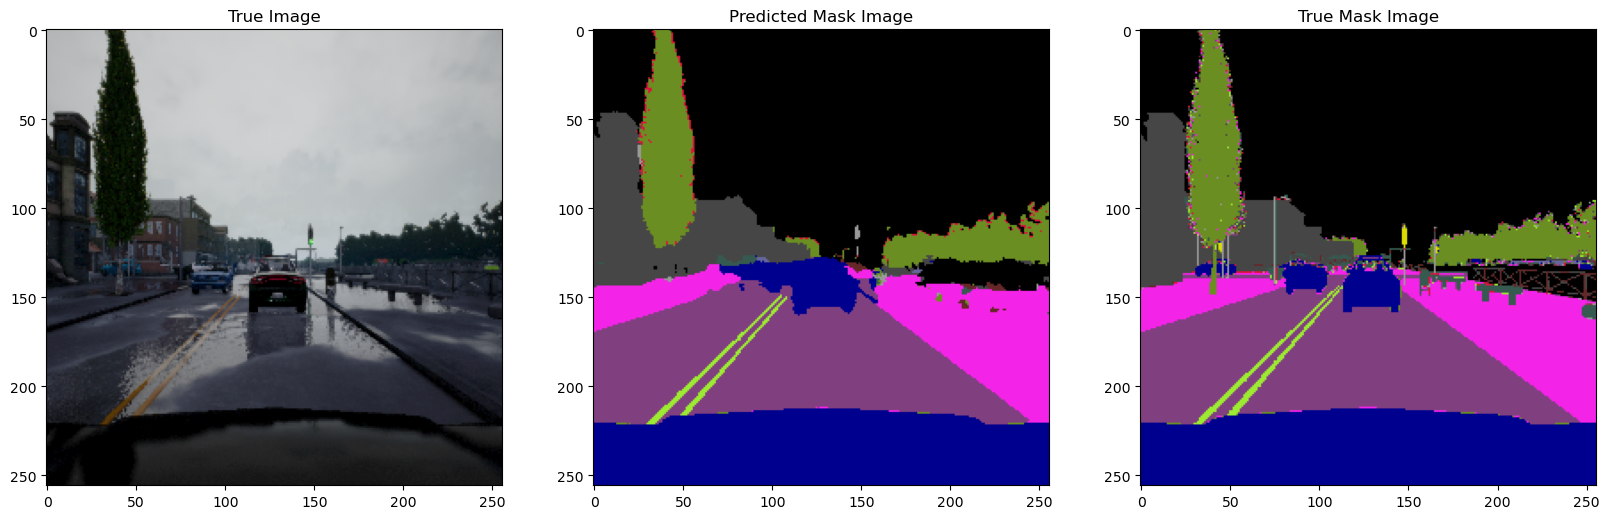

In [67]:
figure, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].set_title('True Image')
ax[0].imshow(X_test[16])
ax[1].set_title('Predicted Mask Image')
ax[1].imshow(seg_color[y_pred_max[16][:,:,0]])
ax[2].set_title('True Mask Image')
ax[2].imshow(seg_color[y_test_max[16][:,:,0]])
plt.show

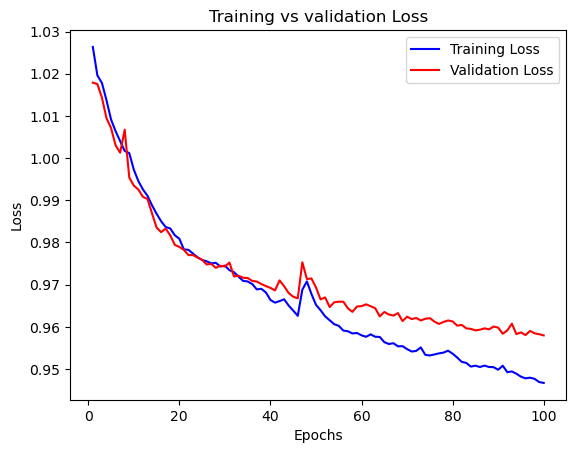

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

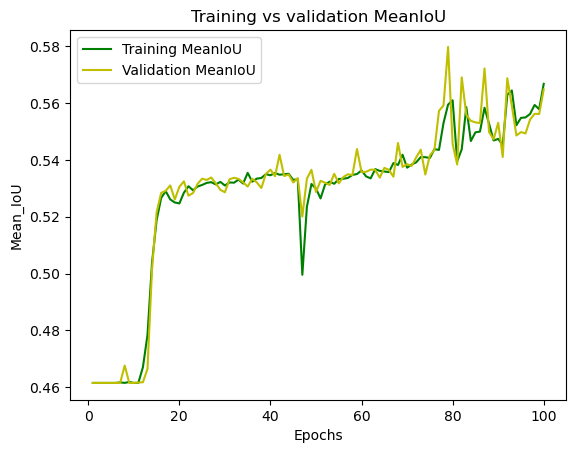

In [74]:
MeanIoU = history.history['mean_io_u']
val_MeanIoU = history.history['val_mean_io_u']
epochs = range(1, len(MeanIoU)+1)
plt.plot(epochs, MeanIoU, 'g', label='Training MeanIoU')
plt.plot(epochs, val_MeanIoU, 'y', label='Validation MeanIoU')
plt.title('Training vs validation MeanIoU')
plt.xlabel('Epochs')
plt.ylabel('Mean_IoU')
plt.legend()
plt.show()

In [78]:
test_img = cv2.imread('/kaggle/input/testmodel/nat-technologyGD01.JPG')

In [80]:
  test_img = cvtBGR2RGB(test_img)
  test_img = cv2.resize(test_img, (256,256))
  test_img = test_img/255

In [82]:
test_img = np.array(test_img)

In [98]:
test_img = np.expand_dims(test_img, axis=0)

In [99]:
test_img.shape

(1, 256, 256, 3)

In [100]:
y_testimg_pred = model.predict(test_img)

1/1 [==============================] - 1s 882ms/step


In [101]:
y_testimg_pred = np.argmax(y_testimg_pred, axis=-1)

In [102]:
y_testimg_pred = np.expand_dims(y_testimg_pred, axis=-1)

In [103]:
y_testimg_pred.shape

(1, 256, 256, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

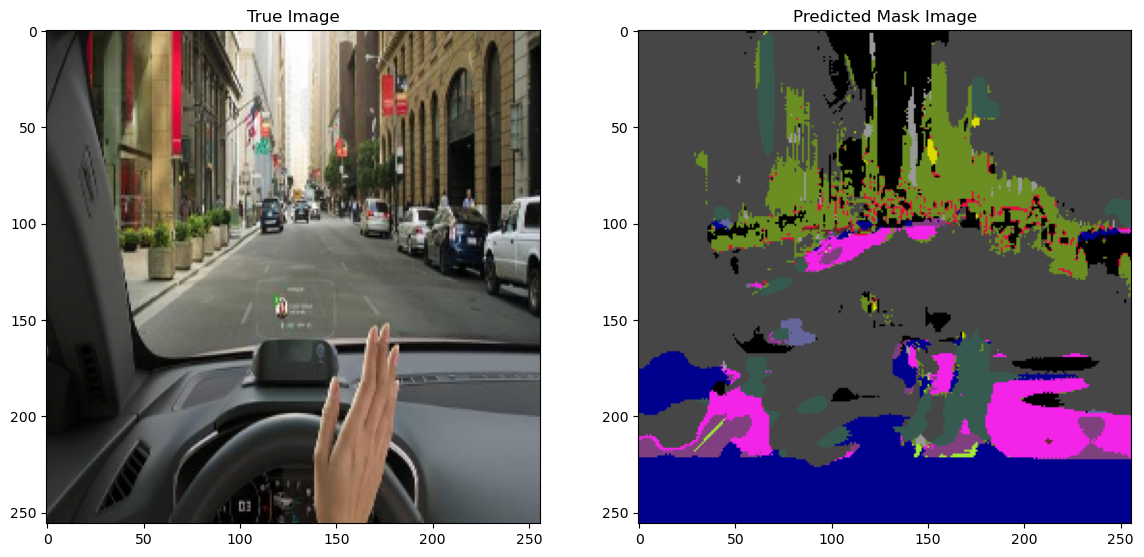

In [106]:
figure, ax = plt.subplots(1,2, figsize=(14,8))
ax[0].set_title('True Image')
ax[0].imshow(test_img[0])
ax[1].set_title('Predicted Mask Image')
ax[1].imshow(seg_color[y_testimg_pred[0][:,:,0]])
plt.show